# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

## Table of Contents <a name='table'></a>
- [Load Data](#Load-Data)
- [Find 'Na' Values](#na)
  - [Explore 'Na' Values](#cleanNa)
  - [Fill 'Na' Values](#fillNa)
- [Explore Target Variable (SalePrice)](#target)
- [Explore Continuous Values](#continuous)

***

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer

## Load Data <a name='Load-Data'></a>
[Table of Cotents](#table)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
X_train_data = train_data.copy()
X_test_data = test_data.copy()

In [5]:
print(X_train_data.shape)
print(X_test_data.shape)

(1460, 81)
(1459, 80)


In [6]:
def get_feature_list(X_train_data=X_train_data):
    cont_features = X_train_data.select_dtypes(include=np.number).columns.tolist()
    cat_features = X_train_data.select_dtypes(include='object').columns.to_list()
    return (cont_features, cat_features)

In [7]:
cont_features, cat_features = get_feature_list()

## Find and Analyse 'NA' Values <a name ='findNa'></a>
[Table of Contents](#table)

In [8]:
def find_na(df):
    na_find = df.isna().any()
    na_values = df.loc[:,na_find]
    na_col = na_values.columns.tolist()
    heatmap = sns.heatmap(X_train_data.isna(),cmap='binary', cbar=False, yticklabels='none')
    return heatmap

<AxesSubplot:>

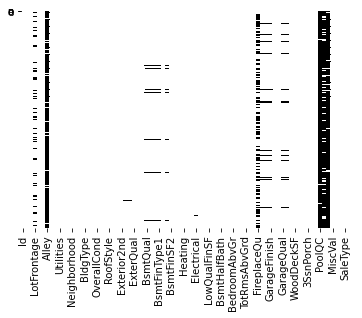

In [9]:
find_na(X_train_data)

<AxesSubplot:>

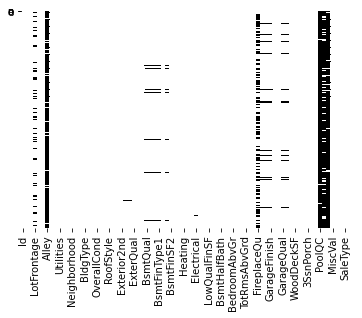

In [10]:
find_na(X_test_data)

In [11]:
na_sum = X_train_data.isna().sum().sort_values(ascending=False)
print(na_sum.loc[na_sum > 0])
print(f'Columns with NaN values: {na_sum.loc[na_sum > 0].count()}')

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
Columns with NaN values: 19


### Clean 'Na' Values <a name='cleanNa'></a>
[Table of Contents](#table)

Comparing our missing values to our data dictionary many of these 'na' values are a descriptive feature of a dwelling that does not have said feature. 'PoolQC' houses without a pool don't have a 'Pool Quality' rating.

We will fill these 'na' values with 'dna' for does not apply since this is a feature in it of itself.

Column Name| 'Na' Description
-----------|---------------
MiscFeature | None
PoolQC | No Pool
Alley | No alley access
BsmtFinType1 | No Basement
Fence | No Fence
Fireplace | No Fireplace
FireplaceQu | No Fireplace
GarageQual | No Garage
GarageFinish | No Garage
GarageCond | No Garage
GarageType | No Garage    
BsmtExposure | No Basement
BsmtCond | No Basement
BsmtQual | No Basement
BsmtFinType2 | No Basement
BsmtFullBath | None
BsmtHalfBath | None
GarageArea | No Garage

LotFrontage is a measurement.  We will fill this with '0'.
All other NA

In [12]:
dna = ['PoolQC','Alley','BsmtFinType1','Fence','Fireplaces',\
       'FireplaceQu','GarageQual','GarageFinish','GarageCond',\
       'GarageType','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2',\
       'BsmtFullBath','BsmtHalfBath','GarageArea','MiscFeature']
zero_measure = ['LotFrontage','MasVnrArea','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2']

In [13]:
def impute(df, feature1, feature2):
    
    dna_imputer = SimpleImputer(fill_value='dna',strategy='constant', add_indicator=False)
    dna_out = dna_imputer.fit_transform(df[feature1])
    df.loc[:,feature1] = dna_out
    
    zero_imputer = SimpleImputer(fill_value=0,strategy='constant')
    zero_out = zero_imputer.fit_transform(df[feature2])
    df.loc[:,feature2] = zero_out
    
    print(df.isna().sum().sort_values(ascending=False))

In [14]:
impute(X_train_data, dna, zero_measure)

GarageYrBlt     81
MasVnrType       8
Electrical       1
SalePrice        0
ExterCond        0
                ..
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
Id               0
Length: 81, dtype: int64


Minimal 'Na' values after imputation.  Dropping remaining rows with 'Na' values.

In [15]:
X_train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,dna,Reg,Lvl,AllPub,...,0,dna,dna,dna,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,dna,Reg,Lvl,AllPub,...,0,dna,dna,dna,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,12,2008,WD,Normal,250000


In [16]:
garage_mode = X_train_data['GarageYrBlt'].mode()[0]
X_train_data['GarageYrBlt'].fillna(garage_mode, inplace=True)
X_train_data.dropna(inplace=True)
X_train_data.dropna(inplace=True)

In [17]:
(X_train_data.isna().any or X_test.isna().any) == True

False

---

## Target Variable (SalePrice) <a name='target'></a>
[Table of Contents](#table)

In [18]:
y_train = X_train_data['SalePrice']

Original Skew: 1.8831110462405252
Transformed Skew: 0.1219499636780384


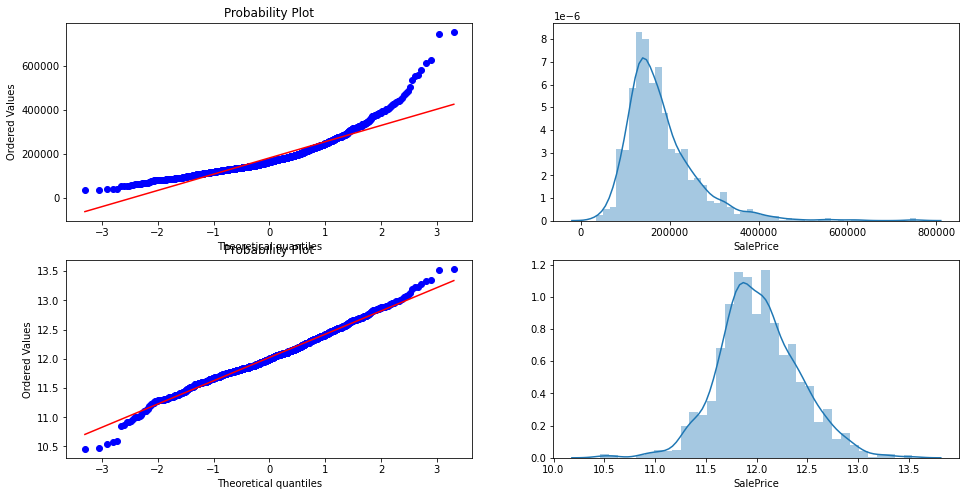

In [19]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
stats.probplot(y_train, dist='norm', fit=True, plot=plt.gca())
plt.subplot(2,2,2)
sns.distplot(y_train)

y_log1p = np.log1p(y_train)
plt.subplot(2,2,3)

stats.probplot(y_log1p, dist='norm', fit=True, plot=plt.gca())
plt.subplot(2,2,4)
sns.distplot(y_log1p)
print(f'Original Skew: {y_train.skew()}')
print(f'Transformed Skew: {y_log1p.skew()}')

---

## Continuous Features <a name='continuous'></a>
[Table of Contents](#table)

In [20]:
corr = X_train_data.corr(method='pearson')

<AxesSubplot:>

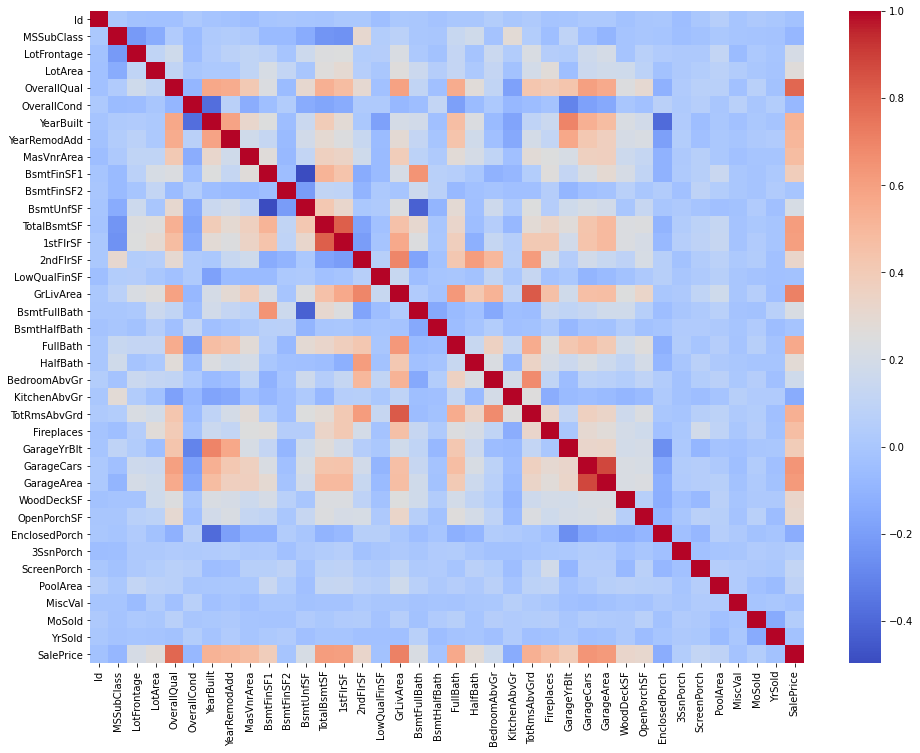

In [21]:
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm')

In [22]:
corr_values = X_train_data.loc[:,cont_features].corrwith(X_train_data.SalePrice) \
.sort_values(ascending=False)

<AxesSubplot:>

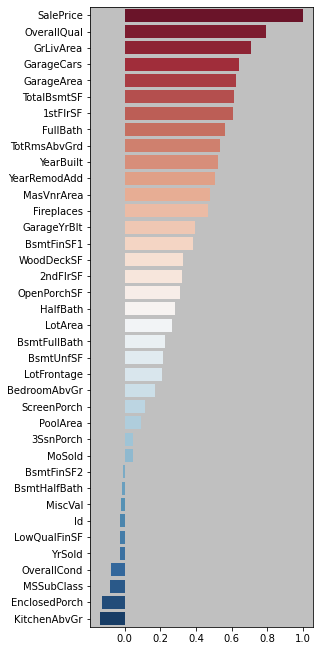

In [23]:
plt.figure(figsize=(4, len(cont_features) * .30))
plt.gca(facecolor='silver')
sns.barplot(x=corr_values,y=corr_values.index, orient='h', palette='RdBu')

In [24]:
ordinal_features = []

def sort(column, sort):
    
    if sort == 'ordinal':
        ordinal_features.append(column)
        print(f'{column} Has been added to the ordinal feature list.')

    elif sort == 'one_hot':
        one_hot_features.append(column)
        print(f'{column} Has been added to the one_hot feature list.')
         
    else:
        return 'Unkown sort value'
    
    return

In [25]:
def outlier_finder(column, df=X_train_data):
    stats = df[column].describe()
    q1 = stats[4]
    q3 = stats[6]
    IQR = q3 - q1
    outliers = (df[(df[column] > q3+1.5 * IQR)]).index
   
    return len(outliers)

In [26]:
def scribe_stats(column, df=X_train_data):
    
    fig = plt.figure(figsize=(16,4), tight_layout=True)
    
    fig.subplots(1,3)
    
    fig.suptitle(f'Feature Label: {str(column)}', size=20)
    
    plt.subplot(1,3,1)
    sns.distplot(df[column])
    
    plt.subplot(1,3,2)
    sns.boxplot(data=df[column])

    plt.subplot(1,3,3)
    sns.scatterplot(x=df[column],y=df.SalePrice)
    
    plt.show()
    
    outlier_count = outlier_finder(column)
    
    print(f'Skew: {df[column].skew()},\nKurtosis: {df[column].kurtosis()},\n\n\
Outlier Count: {outlier_count}\n\n{df[column].describe()}')
    return

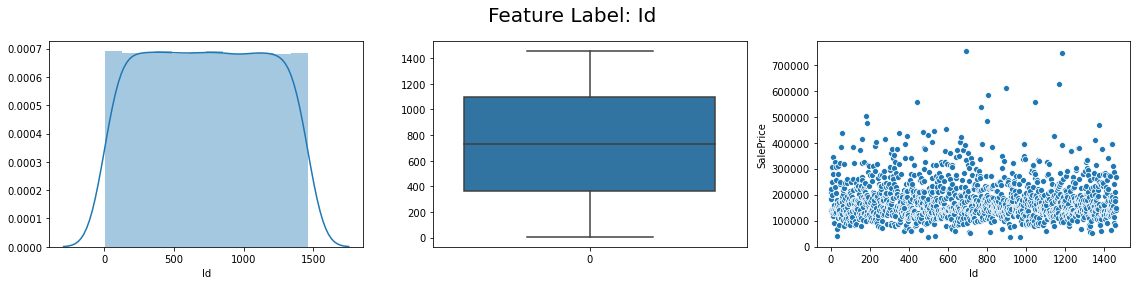

Skew: 0.0035760767396783395,
Kurtosis: -1.1999424189355115,

Outlier Count: 0

count    1451.000000
mean      729.374225
std       421.737858
min         1.000000
25%       364.500000
50%       729.000000
75%      1094.500000
max      1460.000000
Name: Id, dtype: float64


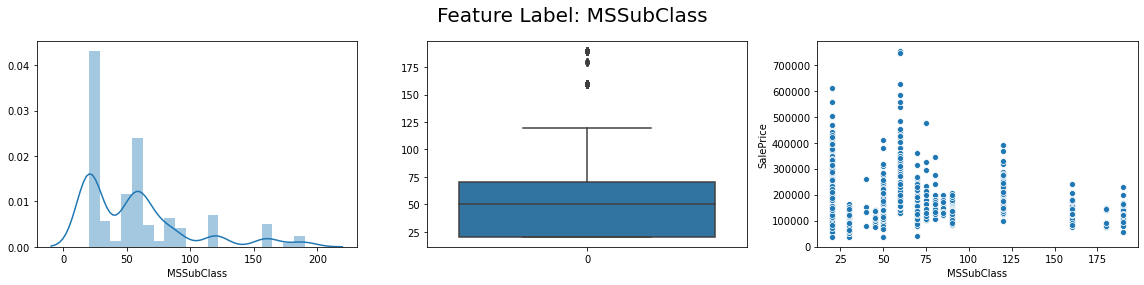

Skew: 1.4082992540425745,
Kurtosis: 1.5772059721439846,

Outlier Count: 103

count    1451.000000
mean       56.933150
std        42.350366
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64


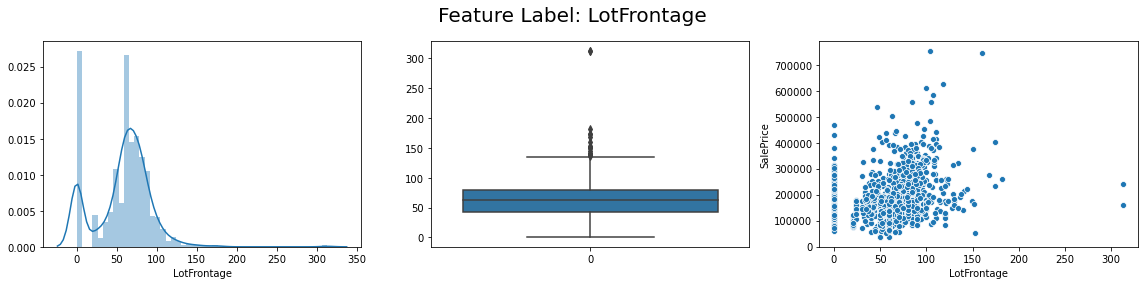

Skew: 0.2730990363240021,
Kurtosis: 3.6437980369059235,

Outlier Count: 16

count    1451.000000
mean       57.624397
std        34.655808
min         0.000000
25%        42.000000
50%        63.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64


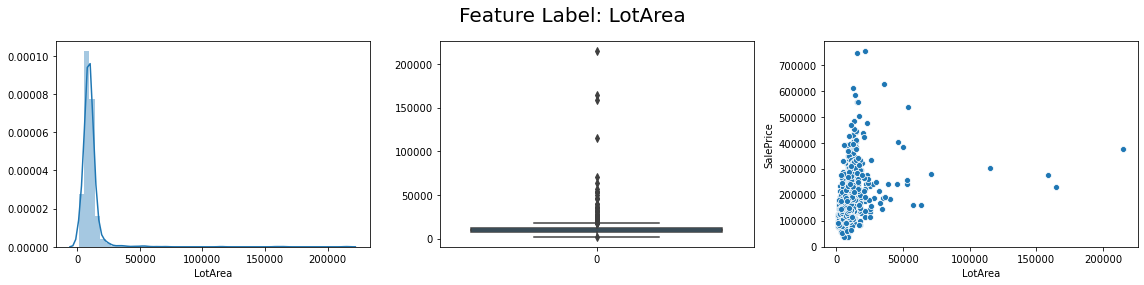

Skew: 12.235741743336332,
Kurtosis: 203.58407874591538,

Outlier Count: 66

count      1451.000000
mean      10507.808408
std        9992.987081
min        1300.000000
25%        7537.500000
50%        9477.000000
75%       11600.000000
max      215245.000000
Name: LotArea, dtype: float64


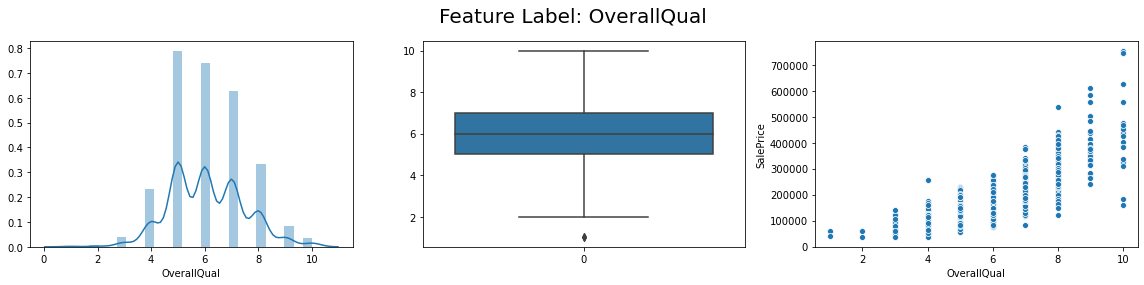

Skew: 0.21340487645467612,
Kurtosis: 0.0855272926681252,

Outlier Count: 0

count    1451.000000
mean        6.093728
std         1.381467
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64


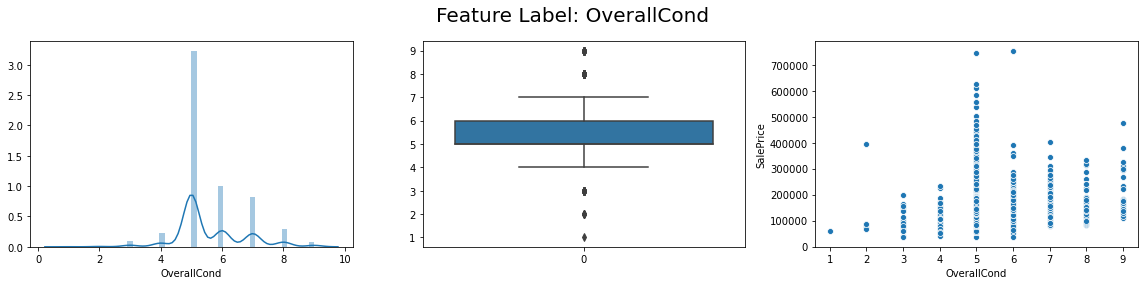

Skew: 0.6939047475284751,
Kurtosis: 1.0919418533306033,

Outlier Count: 94

count    1451.000000
mean        5.579600
std         1.113415
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64


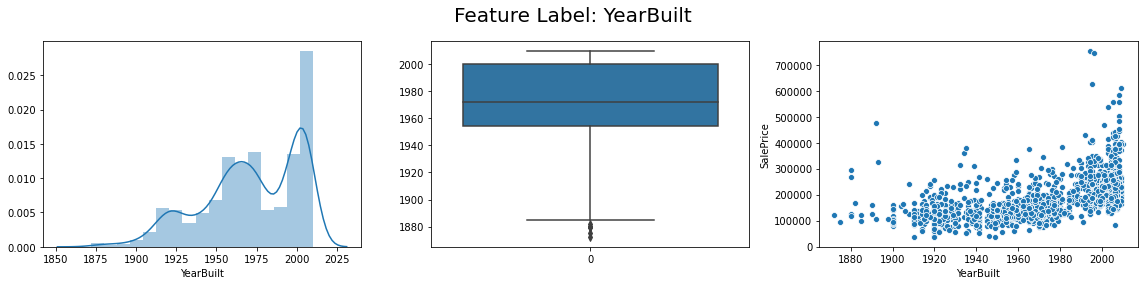

Skew: -0.6082207533833667,
Kurtosis: -0.44237232849021524,

Outlier Count: 0

count    1451.000000
mean     1971.092350
std        30.190266
min      1872.000000
25%      1954.000000
50%      1972.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64


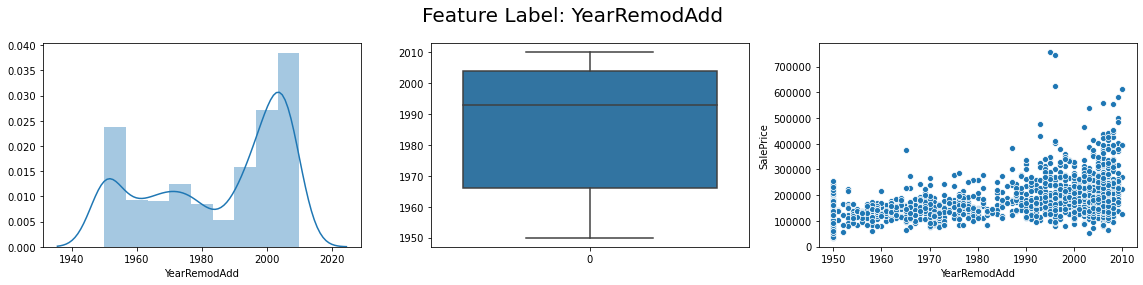

Skew: -0.4963389034442106,
Kurtosis: -1.2795115105819925,

Outlier Count: 0

count    1451.000000
mean     1984.760165
std        20.651334
min      1950.000000
25%      1966.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


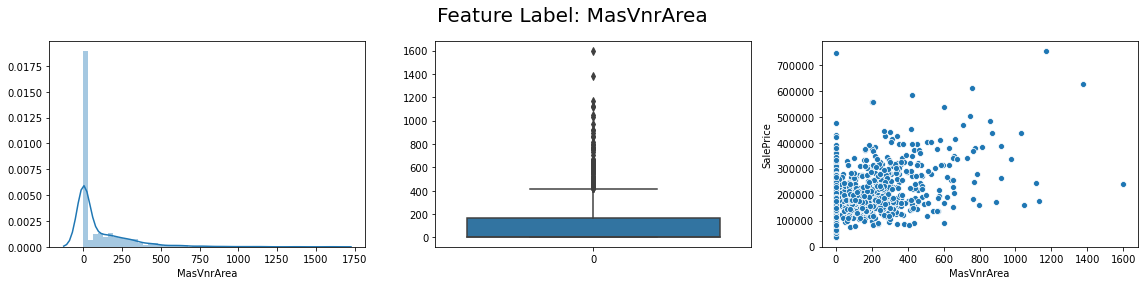

Skew: 2.6680164807560303,
Kurtosis: 10.075050040316713,

Outlier Count: 96

count    1451.00000
mean      103.75672
std       181.10815
min         0.00000
25%         0.00000
50%         0.00000
75%       166.00000
max      1600.00000
Name: MasVnrArea, dtype: float64


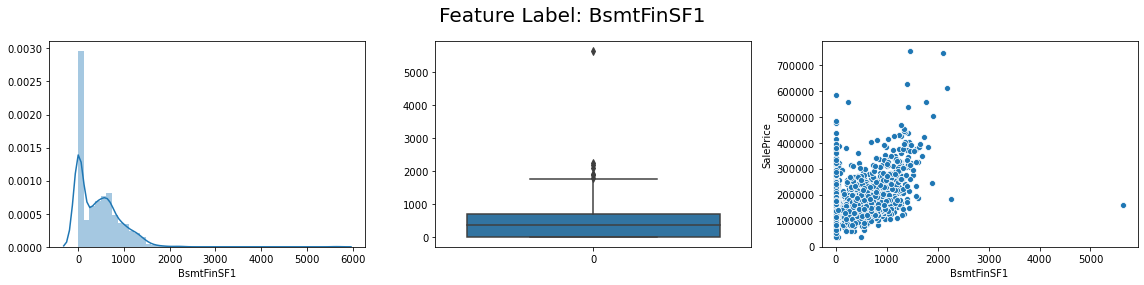

Skew: 1.7025820993769891,
Kurtosis: 11.293695871215649,

Outlier Count: 7

count    1451.000000
mean      442.274983
std       455.369276
min         0.000000
25%         0.000000
50%       381.000000
75%       707.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


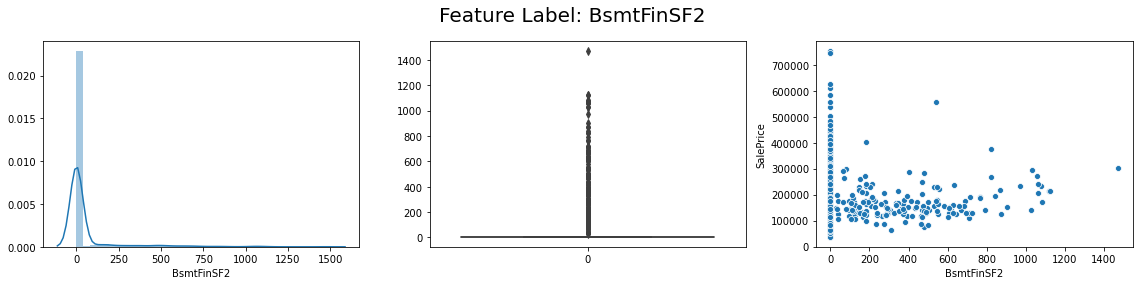

Skew: 4.240229558090081,
Kurtosis: 19.964622505812862,

Outlier Count: 167

count    1451.000000
mean       46.838043
std       161.777324
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64


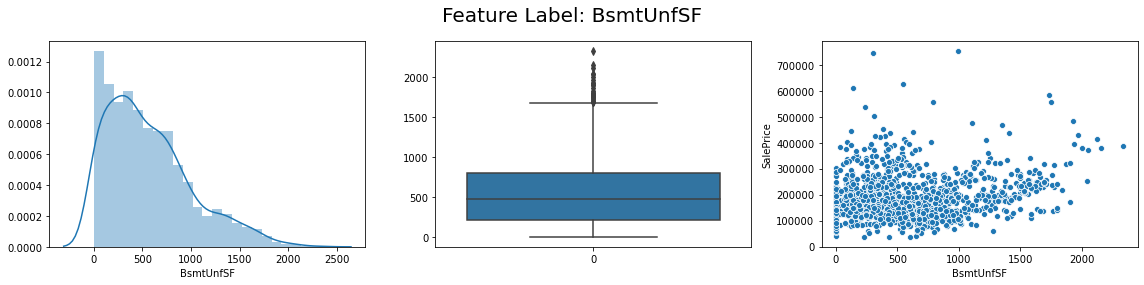

Skew: 0.9199767396130494,
Kurtosis: 0.47511903763031427,

Outlier Count: 28

count    1451.000000
mean      567.197105
std       442.209192
min         0.000000
25%       222.000000
50%       479.000000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


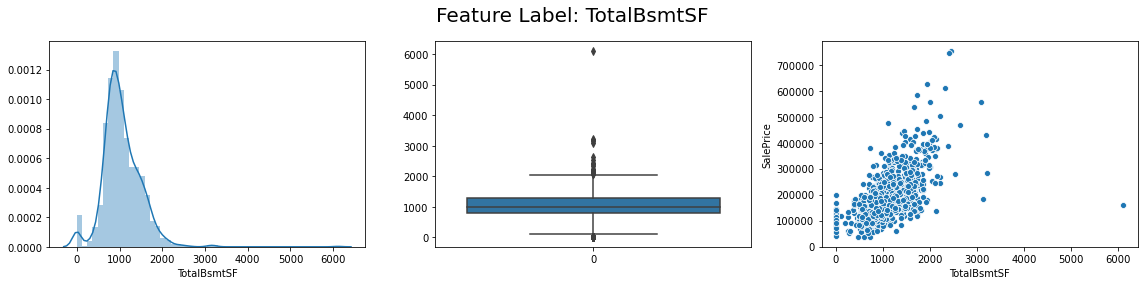

Skew: 1.5355663165360056,
Kurtosis: 13.44412043406942,

Outlier Count: 23

count    1451.000000
mean     1056.310131
std       437.914609
min         0.000000
25%       795.000000
50%       991.000000
75%      1297.500000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


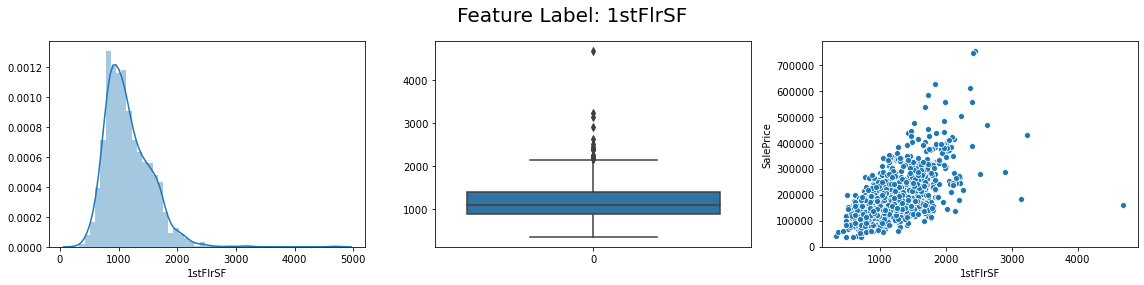

Skew: 1.373141509130297,
Kurtosis: 5.832535396333348,

Outlier Count: 19

count    1451.000000
mean     1161.551344
std       385.002532
min       334.000000
25%       882.000000
50%      1086.000000
75%      1391.000000
max      4692.000000
Name: 1stFlrSF, dtype: float64


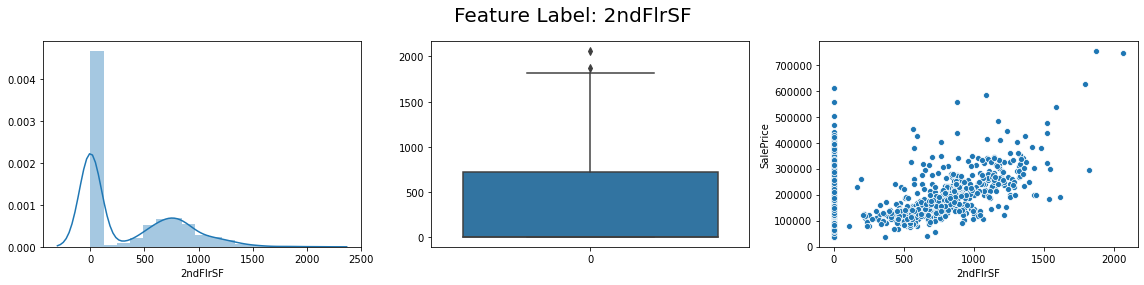

Skew: 0.8157663449459674,
Kurtosis: -0.545279781280025,

Outlier Count: 2

count    1451.000000
mean      346.742247
std       436.453277
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


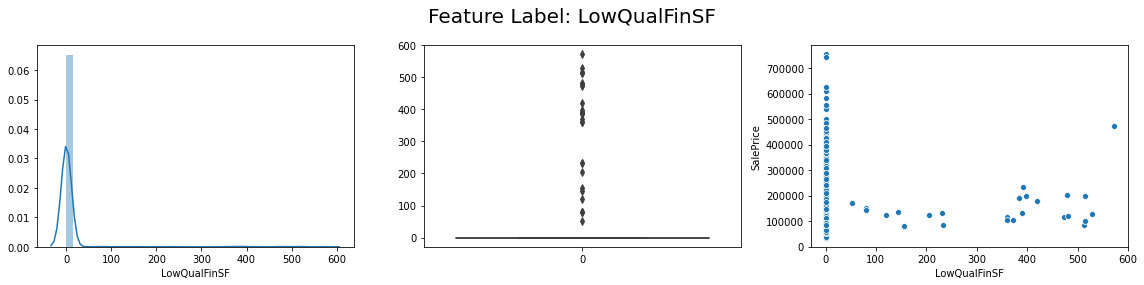

Skew: 8.982567341903248,
Kurtosis: 82.69356902297045,

Outlier Count: 26

count    1451.000000
mean        5.880772
std        48.771560
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64


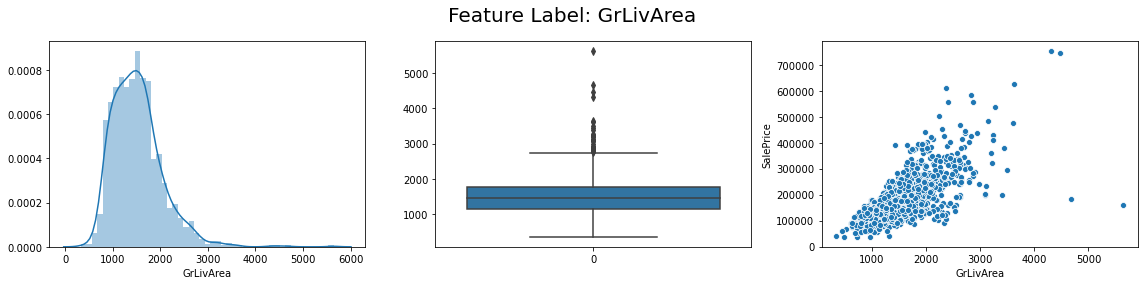

Skew: 1.3735124123402647,
Kurtosis: 4.927435795783476,

Outlier Count: 31

count    1451.000000
mean     1514.174363
std       525.799521
min       334.000000
25%      1128.000000
50%      1464.000000
75%      1776.000000
max      5642.000000
Name: GrLivArea, dtype: float64


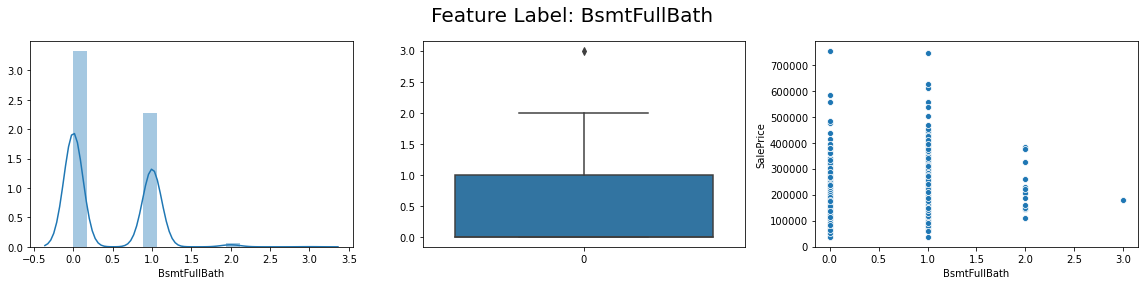

Skew: 0.6041894810109277,
Kurtosis: -0.824718148554695,

Outlier Count: 1

count    1451.000000
mean        0.423846
std         0.518842
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64


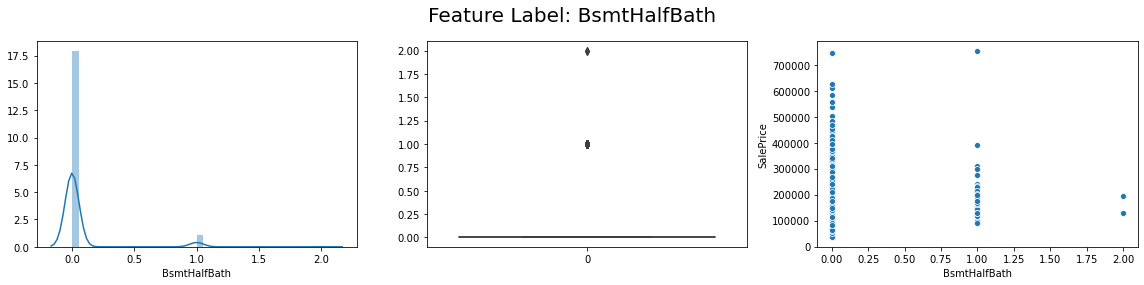

Skew: 4.088583470927076,
Kurtosis: 16.266840766681618,

Outlier Count: 82

count    1451.000000
mean        0.057891
std         0.239449
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64


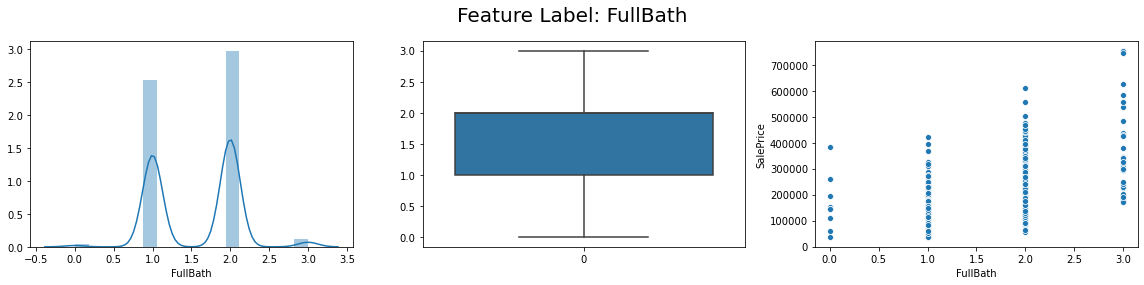

Skew: 0.037756439286998095,
Kurtosis: -0.8680872124225907,

Outlier Count: 0

count    1451.000000
mean        1.562371
std         0.550301
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64


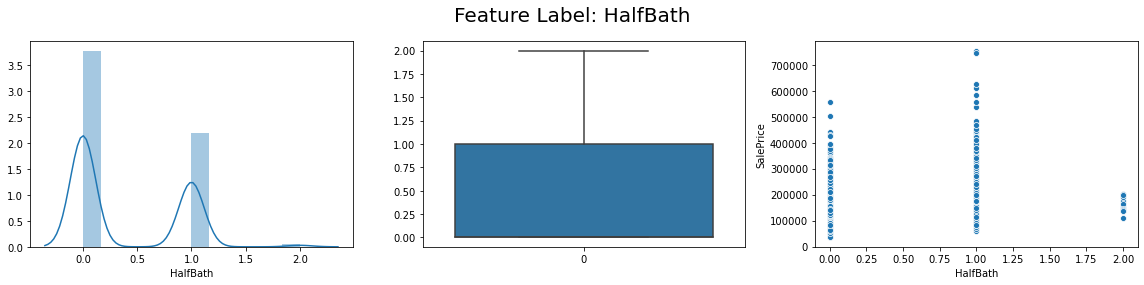

Skew: 0.6851276113330176,
Kurtosis: -1.060728352860473,

Outlier Count: 0

count    1451.000000
mean        0.381116
std         0.502574
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64


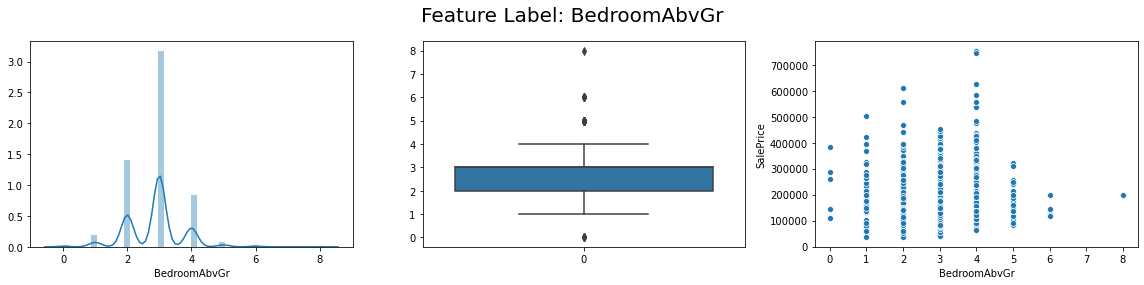

Skew: 0.21784687671324457,
Kurtosis: 2.254820678690478,

Outlier Count: 29

count    1451.000000
mean        2.866988
std         0.815086
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64


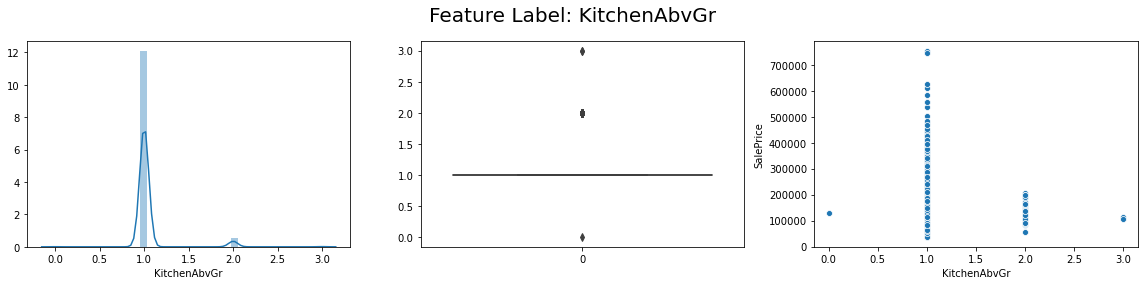

Skew: 4.512817302504021,
Kurtosis: 21.819197404098166,

Outlier Count: 66

count    1451.000000
mean        1.046175
std         0.219571
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64


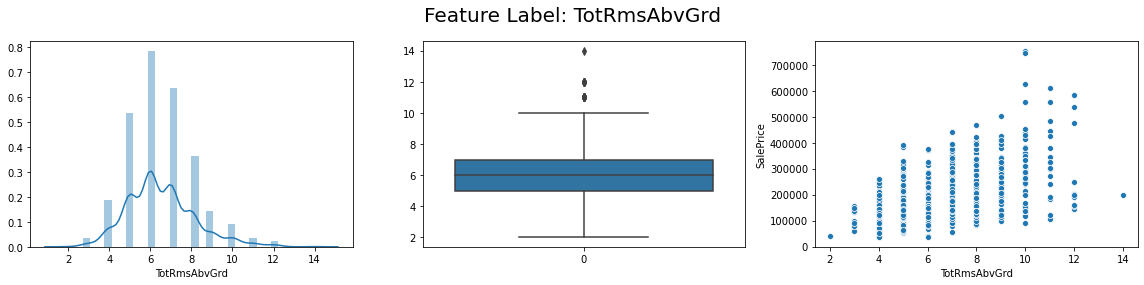

Skew: 0.6808626334316268,
Kurtosis: 0.8863725363554393,

Outlier Count: 30

count    1451.000000
mean        6.516885
std         1.626576
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64


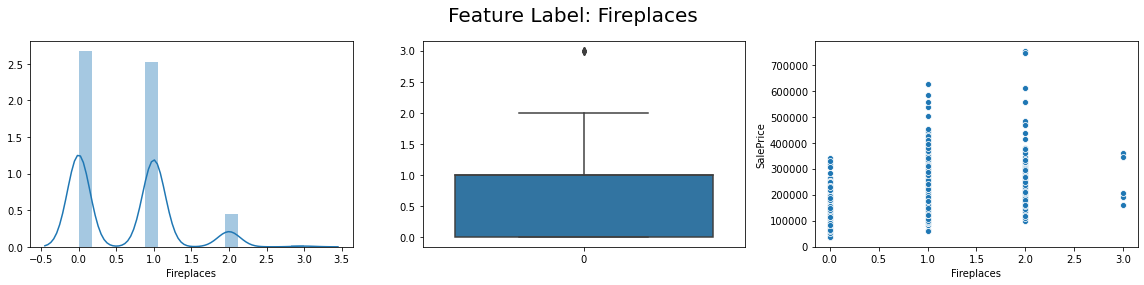

Skew: 0.6477441194695555,
Kurtosis: -0.21007698265350427,

Outlier Count: 5

count    1451.000000
mean        0.612681
std         0.643443
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64


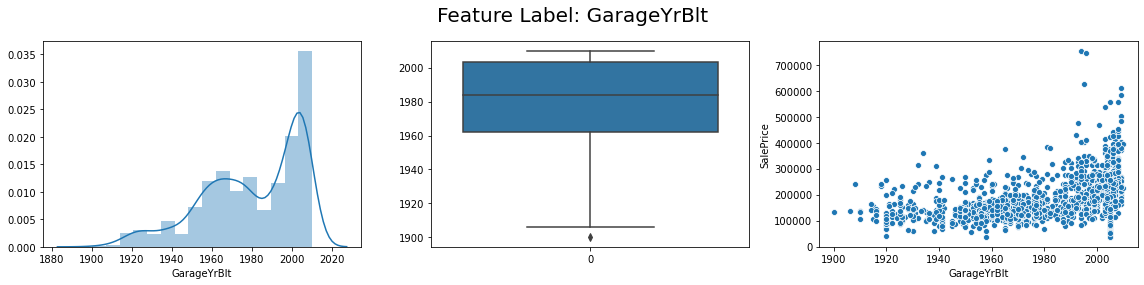

Skew: -0.7128268463521222,
Kurtosis: -0.3702772904514444,

Outlier Count: 0

count    1451.000000
mean     1979.840799
std        24.754745
min      1900.000000
25%      1962.000000
50%      1984.000000
75%      2003.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64


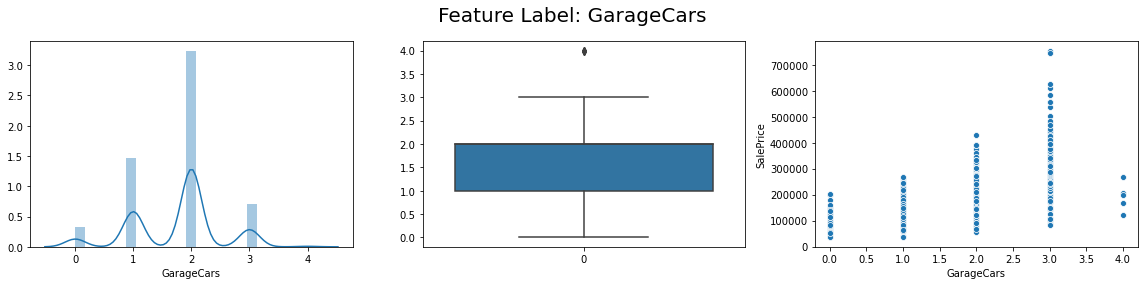

Skew: -0.3374185582736461,
Kurtosis: 0.20757493259321524,

Outlier Count: 5

count    1451.000000
mean        1.764990
std         0.748728
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64


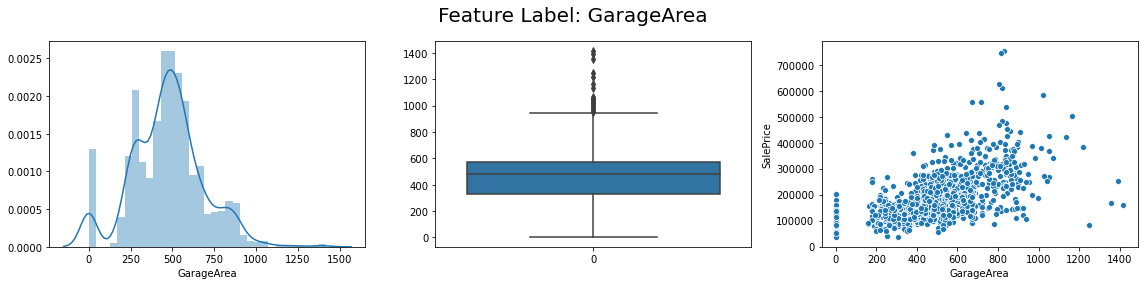

Skew: 0.18258498282307278,
Kurtosis: 0.9092646116469947,

Outlier Count: 20

count    1451.000000
mean      472.525155
std       214.171752
min         0.000000
25%       327.500000
50%       478.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64


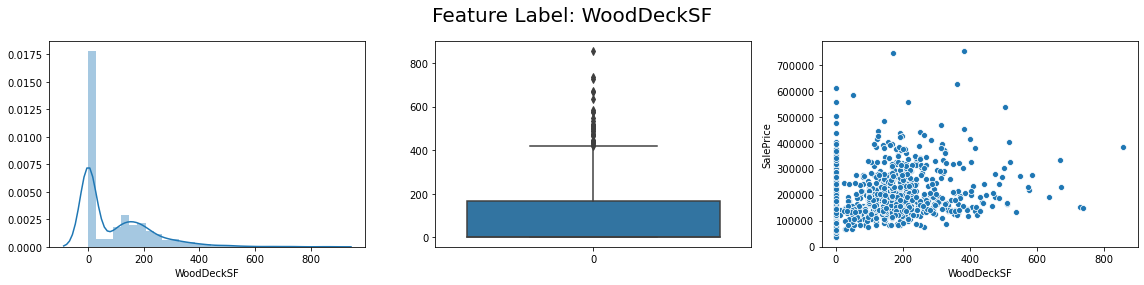

Skew: 1.5418716169970634,
Kurtosis: 2.9972592856988975,

Outlier Count: 32

count    1451.000000
mean       94.412819
std       125.436852
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64


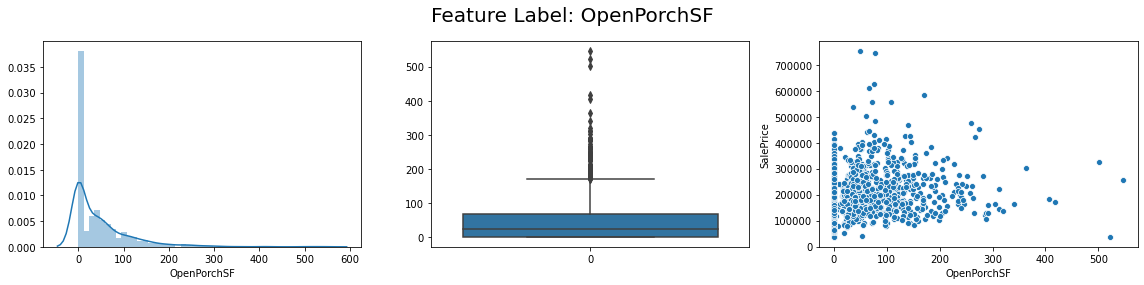

Skew: 2.38490828478105,
Kurtosis: 8.664993444939986,

Outlier Count: 75

count    1451.000000
mean       46.422467
std        66.060150
min         0.000000
25%         0.000000
50%        24.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64


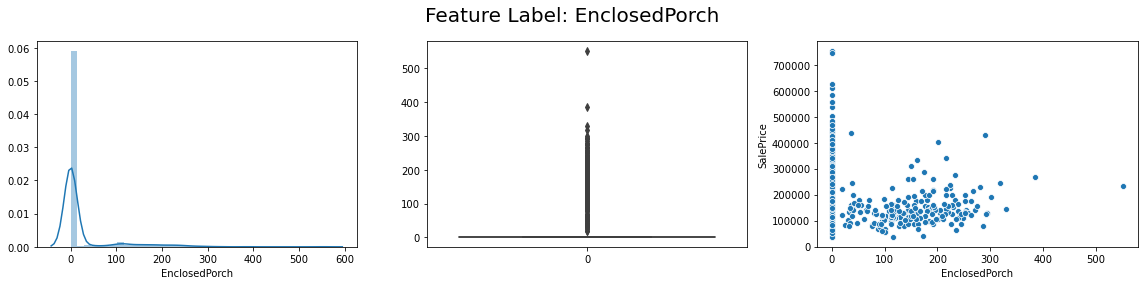

Skew: 3.0940010943007756,
Kurtosis: 10.474484840844404,

Outlier Count: 207

count    1451.000000
mean       21.952447
std        61.108223
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64


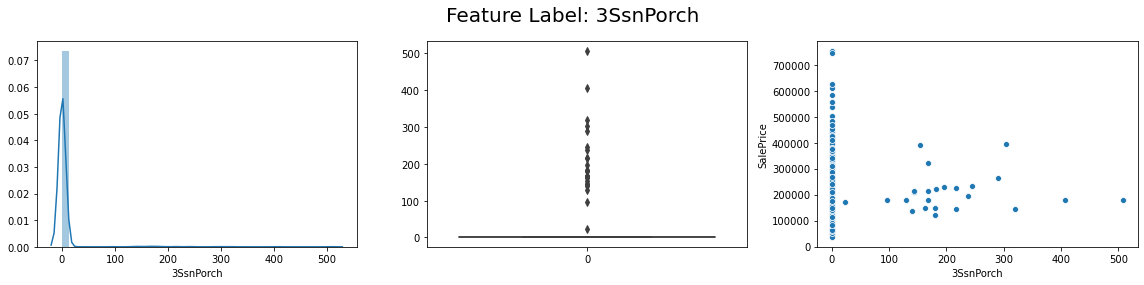

Skew: 10.271741500340108,
Kurtosis: 122.87569154925335,

Outlier Count: 24

count    1451.000000
mean        3.430737
std        29.406940
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


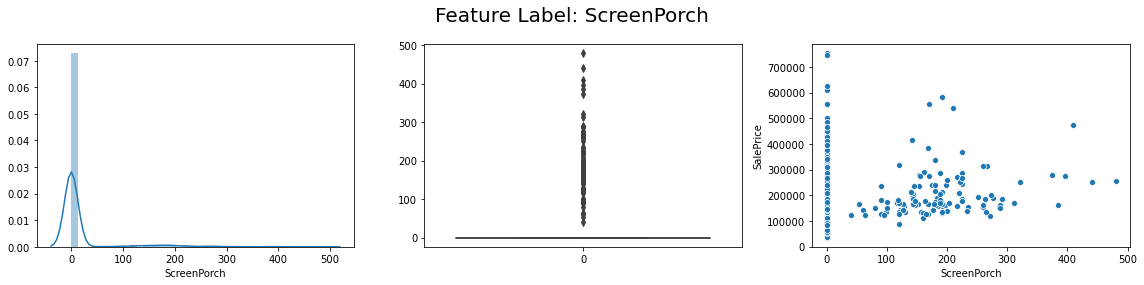

Skew: 4.107410708562218,
Kurtosis: 18.299030438469984,

Outlier Count: 116

count    1451.000000
mean       15.154376
std        55.917522
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64


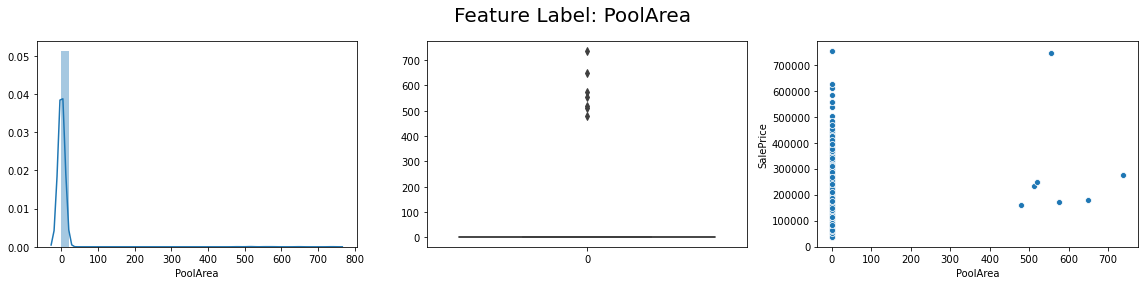

Skew: 14.78206884801823,
Kurtosis: 221.86638768108665,

Outlier Count: 7

count    1451.000000
mean        2.776017
std        40.301212
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64


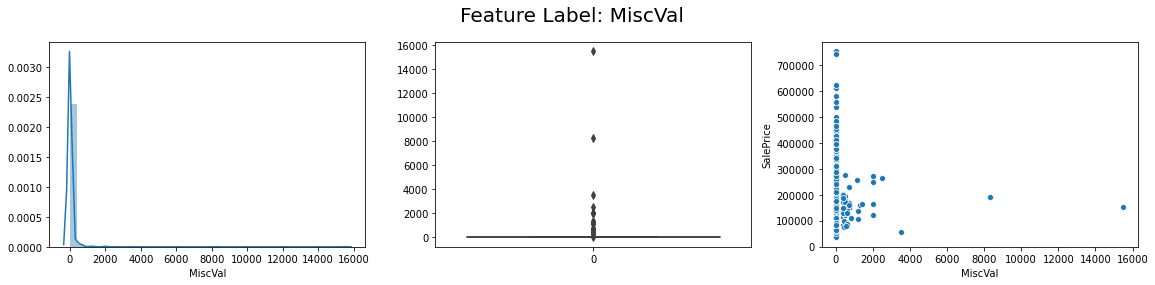

Skew: 24.40151268294567,
Kurtosis: 696.6920940462784,

Outlier Count: 52

count     1451.000000
mean        43.758787
std        497.648467
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64


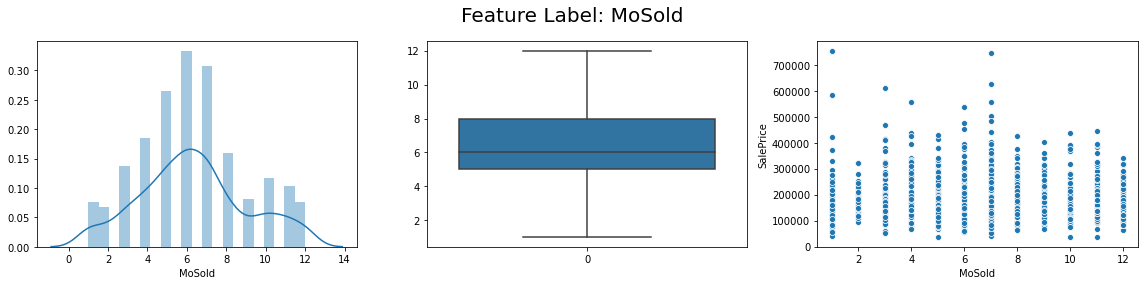

Skew: 0.20925735665718795,
Kurtosis: -0.3981785028625402,

Outlier Count: 0

count    1451.000000
mean        6.319090
std         2.700353
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64


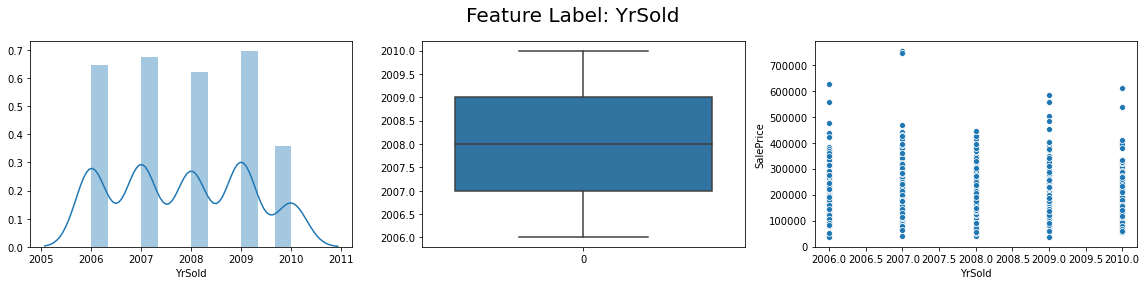

Skew: 0.09613220774566901,
Kurtosis: -1.1943163004354846,

Outlier Count: 0

count    1451.000000
mean     2007.815300
std         1.329376
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64


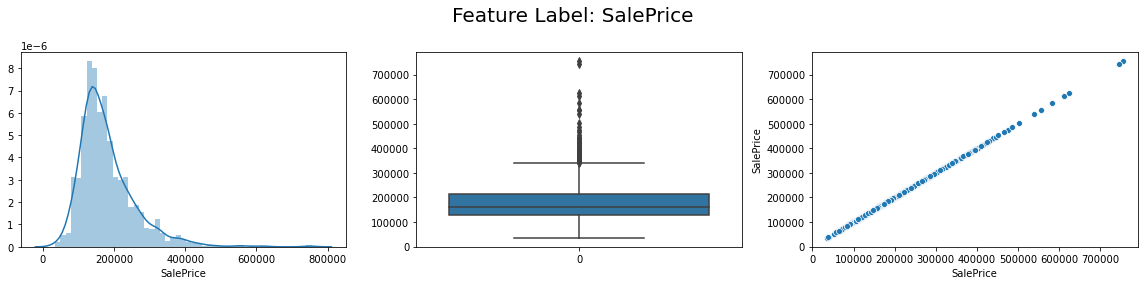

Skew: 1.8831110462405252,
Kurtosis: 6.573025006423077,

Outlier Count: 60

count      1451.000000
mean     180624.101999
std       79312.128273
min       34900.000000
25%      129900.000000
50%      162500.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [27]:
for _ in cont_features:
    scribe_stats(_)

## Observations of continuous variables ##
- [ ] The **Id** and **SalePrice** feature columns need to be dropped.
- [ ] There are features that has a continuous data type that is actually categorical in nature. I will change this for the following features.
 - *__'YrSold', 'MoSold', 'MSSubClass', 'OverallCond'__*.
- [x] There are features with ordinal values.  I will create a dictionary with their name and order values for later encoding.
  - *__'OverallQual', 'OverallCond', 'MoSold', 'YrSold'__*.
- [ ] There are features that have a really high skew.  I will do a box-cox transform on these features to see if we can get a more gaussian distribution.
  - 
- [ ] There are quite a few outliers.  I will look into this after performing the box-cox transform.

In [28]:
one_hot_features = ['YrSold', 'MoSold', 'MSSubClass', 'OverallQual', \
                    'OverallCond', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']  

for c in one_hot_features:
    X_train_data[c] = X_train_data[c].astype('object')

In [29]:
cont_features, _ = get_feature_list()

In [30]:
skew_values = X_train_data.loc[:,cont_features].apply(lambda x: x.skew()) \
.sort_values(ascending=False)
skew_values

MiscVal          24.401513
PoolArea         14.782069
LotArea          12.235742
3SsnPorch        10.271742
LowQualFinSF      8.982567
KitchenAbvGr      4.512817
BsmtFinSF2        4.240230
ScreenPorch       4.107411
BsmtHalfBath      4.088583
EnclosedPorch     3.094001
MasVnrArea        2.668016
OpenPorchSF       2.384908
SalePrice         1.883111
BsmtFinSF1        1.702582
WoodDeckSF        1.541872
TotalBsmtSF       1.535566
GrLivArea         1.373512
1stFlrSF          1.373142
BsmtUnfSF         0.919977
2ndFlrSF          0.815766
HalfBath          0.685128
TotRmsAbvGrd      0.680863
Fireplaces        0.647744
BsmtFullBath      0.604189
LotFrontage       0.273099
BedroomAbvGr      0.217847
GarageArea        0.182585
FullBath          0.037756
Id                0.003576
GarageCars       -0.337419
dtype: float64

In [31]:
high_skew = X_train_data.loc[:,cont_features].skew() > .5

In [32]:
from scipy.special import boxcox1p

for s in high_skew.index:
    X_train_data[s] = boxcox1p(X_train_data[s], stats.boxcox_normmax(X_train_data[s]+1))

C:\Users\Brian\miniconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Brian\miniconda3\lib\site-packages\scipy\stats\stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [33]:
X_train_data.loc[:,cont_features].apply(lambda x: x.skew()) \
.sort_values(ascending=False)

PoolArea         14.446233
3SsnPorch         7.727508
LowQualFinSF      7.376407
MiscVal           5.188016
KitchenAbvGr      3.973101
BsmtHalfBath      3.915052
ScreenPorch       3.319606
BsmtFinSF2        2.637316
EnclosedPorch     2.286415
MasVnrArea        0.947274
2ndFlrSF          0.884180
WoodDeckSF        0.775576
HalfBath          0.720391
OpenPorchSF       0.627257
BsmtFullBath      0.597854
Fireplaces        0.513201
TotalBsmtSF       0.456458
BsmtFinSF1        0.382781
LotFrontage       0.323659
GarageArea        0.197737
BsmtUnfSF         0.053324
TotRmsAbvGrd      0.041255
FullBath          0.034557
SalePrice         0.029716
BedroomAbvGr      0.026351
GrLivArea         0.006049
1stFlrSF         -0.008257
GarageCars       -0.086068
Id               -0.184282
LotArea          -0.188691
dtype: float64

In [34]:
for o in cont_features:
    print(f'{o}: {outlier_finder(o)}')

Id: 0
LotFrontage: 16
LotArea: 37
MasVnrArea: 2
BsmtFinSF1: 1
BsmtFinSF2: 167
BsmtUnfSF: 1
TotalBsmtSF: 16
1stFlrSF: 4
2ndFlrSF: 4
LowQualFinSF: 26
GrLivArea: 6
BsmtFullBath: 1
BsmtHalfBath: 82
FullBath: 0
HalfBath: 0
BedroomAbvGr: 29
KitchenAbvGr: 66
TotRmsAbvGrd: 12
Fireplaces: 5
GarageCars: 5
GarageArea: 20
WoodDeckSF: 5
OpenPorchSF: 3
EnclosedPorch: 207
3SsnPorch: 24
ScreenPorch: 116
PoolArea: 7
MiscVal: 52
SalePrice: 12


In [62]:
def outlier_removal(column, df=X_train_data):
    q90 = df[column].quantile(.9)
    outliers = (df[(df[column] > q90)]).index
    df.drop(outliers, inplace=True)
    return df

In [63]:
X_train_data[cont_features].transform(outlier_removal(cont_features))

AttributeError: 'MSSubClass' is not a valid function for 'Series' object

In [64]:
cont_features

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [55]:
for o in cont_features:
    print(f'{o}: {outlier_finder(o)}')

784.4960365841249

## Catigorical Features <a name='catigorical'></a>
[Table of Contents](#table)

---

In [35]:
def column_clean(df):
    
    if ('Id' in df.columns):
        df.drop(columns='Id', axis=1, inplace=True)
        cont_features.remove('Id')
    if ('SalePrice' in df.columns):
        df.drop(columns='SalePrice', axis=1, inplace=True)
        cont_features.remove('SalePrice')

    
    cat_features.extend(one_hot_features)
#     cat_features.extend(category_features)
 
    final_cont = list(set(cont_features) - set(ordinal_features) - set(one_hot_features))
    final_cat = list(set(cat_features) - set(ordinal_features))
    
    return (final_cont, final_cat)

In [36]:
cont_f, cat_f = column_clean(X_train_data)

In [37]:
 ordinal_dict = {'OverallQual':[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                 'OverallCond':[1, 2, 3, 4, 5, 6, 7, 8, 9],
                 'MoSold':[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
                 'YrSold':[2006, 2007, 2008, 2009, 2010],
                 'BsmtQual':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'BsmtCond':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'BsmtFinType1':['dna','Unf','LwQ','Rec','BLQ', 'ALQ', 'GLQ'],
                 'BsmtFinType2':['dna','Unf','LwQ','Rec','BLQ', 'ALQ', 'GLQ'],
                 'HeatingQC':['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'KitchenQual':['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'Functional':['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                 'FireplaceQu':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'GarageQual':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'GarageCond':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'PoolQC':['dna','Fa', 'Gd','Ex'],
                 'Fence':['dna', 'MnWw', 'GdWo','MnPrv', 'GdPrv']}


In [38]:
ordinal_list = [value for key,value in ordinal_dict.items()]

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, BayesianRidge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score

### Pipeline <a name='Pipeline'></a>
[Table of Contents](#table)

In [40]:
continuous_transform = Pipeline([
    ('scaler', StandardScaler()),
])

In [41]:
categorical_transform = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

In [42]:
ordinal_transform = Pipeline([
    ('ordinal', OrdinalEncoder()),
])

In [43]:
preprocessor = ColumnTransformer([
    ('cont', StandardScaler(), cont_f),
    ('ordinal', OrdinalEncoder(categories=ordinal_list),ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_f),
])

In [44]:
linear_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Linear', LinearRegression()),
])

In [45]:
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(random_state=24)),
])

In [46]:
huber_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Huber', HuberRegressor(max_iter=2000)),
])

In [47]:
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso(random_state=24, fit_intercept=True)),
])

In [48]:
elastic_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('ElasticNet', ElasticNet(random_state=24))
])

In [49]:
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM', LinearSVR(epsilon=1.5))
])

In [50]:
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Tree', RandomForestRegressor(n_estimators=500, max_leaf_nodes=16,n_jobs=-1))
])

In [51]:
pipe_list = [linear_pipe, ridge_pipe, huber_pipe, lasso_pipe, elastic_pipe, svm_pipe, tree_pipe]

In [52]:
def display_scores():
    
    rmse_dict = dict(Model=[],Mean=[],STD=[],Scores=[])

    for pipe in pipe_list:
        scores = cross_val_score(pipe, X_train_data, log1p, scoring='neg_mean_squared_error', cv=5)
        rmse_pipe = np.sqrt(-scores)
        
        rmse_dict['Model'].append(pipe.steps[1][0])
        rmse_dict['Mean'].append(rmse_pipe.mean())
        rmse_dict['STD'].append(rmse_pipe.std())
        rmse_dict['Scores'].append(rmse_pipe)
        
    return pd.DataFrame(rmse_dict)

In [53]:
display_scores()

NameError: name 'log1p' is not defined

In [ ]:
vote_pipe = VotingRegressor([
    ('linear', linear_pipe), ('tree', tree_pipe), ('svc', svm_pipe)],
    n_jobs=-1)

In [ ]:
vote = Pipeline([
    ('preprocessor', preprocessor),
    ('vote',vote_pipe)
])

In [ ]:
scores = cross_val_score(vote_pipe, X_train_data, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_pipe = np.sqrt(-scores)
print(f'{pipe.steps[1][0]}')
print(f'{rmse_pipe.mean()}')
print(f'{rmse_pipe.std()}')
print(f'{rmse_pipe}')

In [ ]:
ada_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('AdaBoost', DecisionTreeRegressor(random_state=24)),
])

In [ ]:
scores = cross_val_score(ada_pipe, X_train_data, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_pipe = np.sqrt(-scores)
print(f'{rmse_pipe.mean()}')
print(f'{rmse_pipe.std()}')
print(f'{rmse_pipe}')